# Bright SNe lightcurves
### Roy Williams
Grab some bright supernovae and plot them.  Demo of:
* /query/
* /lightcurves/

### Python (3 only) requirements - pip install
lasair, matplotlib


In [1]:
!pip3 install lasair

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
endpoint = "https://lasair-ztf.lsst.ac.uk/api"

In [3]:
import sys, time
import matplotlib.pyplot as plt
import numpy as np

### Grab my Lasair API token
Get your Lasair token before you start. You can log into [Lasair](https://lasair.lsst.ac.uk) and click "My Profile"
at top right. Or use the command-line below.
```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
Make a file called settings.py with a line like: `API_TOKEN = '0123456789abcdefxxxxxxxxxxxxxxxxxxxxxxxx'`

In [4]:
from lasair import LasairError, lasair_client as lasair
import settings

L = lasair(settings.API_TOKEN, endpoint=endpoint)

/Users/rwillia5/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Just join the objects table and the sherlock_classifications table, just
# pulling out the objectId.
rows = L.query(
    "objects.objectId",
    'objects, sherlock_classifications',
    """ sherlock_classifications.classification = "SN"
        AND objects.gmag < 19 AND objects.rmag < 19
        AND objects.ncandgp > 12 
    """,
    limit=10)
objectIds = [row['objectId'] for row in rows]
print(objectIds)

['ZTF18aaaehwv', 'ZTF18abcvtgy', 'ZTF18abkhgfg', 'ZTF18abrbaow', 'ZTF18abrwrxh', 'ZTF18abxoqkd', 'ZTF18actxlqb', 'ZTF19aamurgd', 'ZTF19aavqoop', 'ZTF19aavqoyu']


### Plot lightcurve function

In [6]:
def plotLC(objectId, candidates):
    jd_now = time.time()/86400 + 40587.0 + 2400000.5
    color = {1:'green', 2:'red'}
    for fid in [1,2]:
        since = []
        magpsf = []
        sigmapsf = []
        for cand in candidates:
            if cand['fid'] == fid:
                since.append(cand['jd'] - jd_now)
                magpsf.append(cand['magpsf'])
                sigmapsf.append(cand['sigmapsf'])
        plt.errorbar(since, magpsf, yerr=sigmapsf, c=color[fid])
        plt.xlabel("days before %.2f" % jd_now)
        plt.ylabel("psf mag")
        plt.title('https://lasair-ztf.lsst.ac.uk/objects/%s' % objectId)
    plt.gca().invert_yaxis()
    plt.show()

### Grab and plot the lightcurves

In [7]:
lcs = L.lightcurves(objectIds)

For ZTF we have to split the candidates and non-candidates manually.

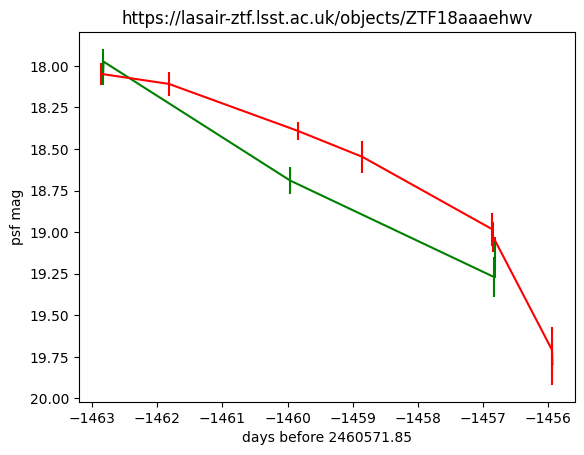

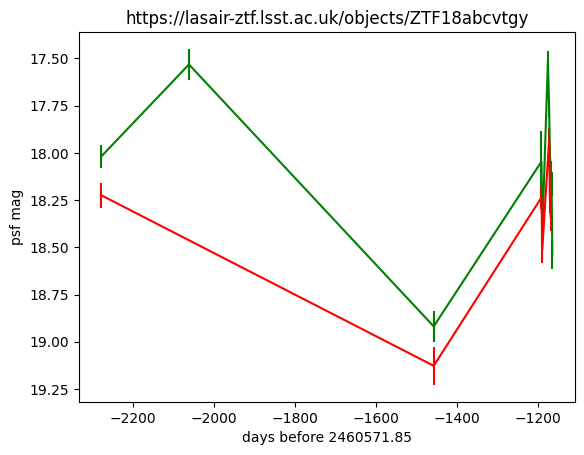

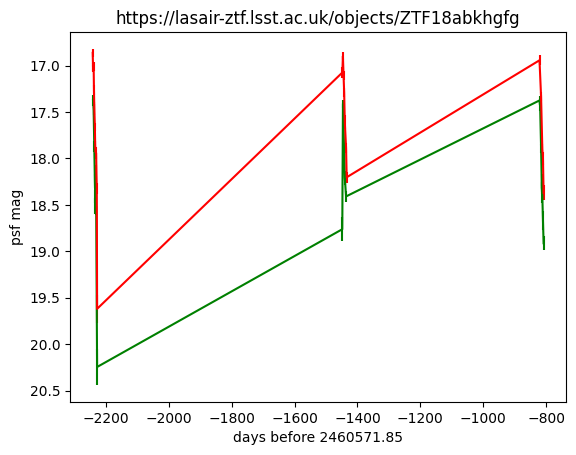

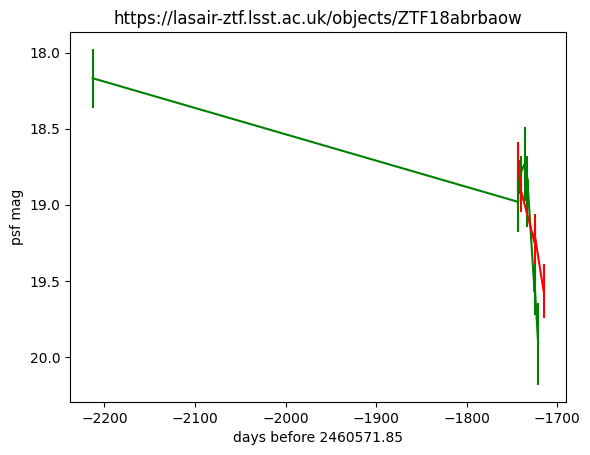

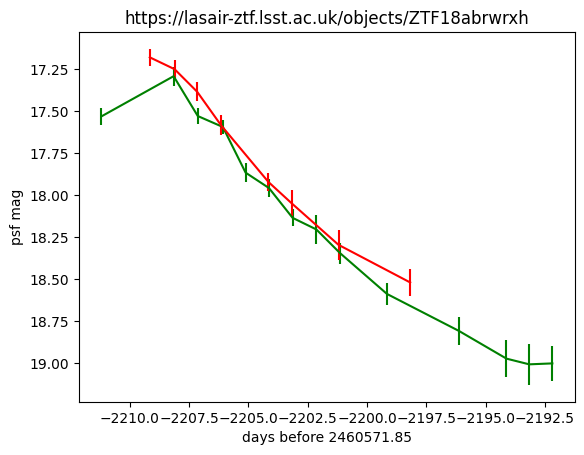

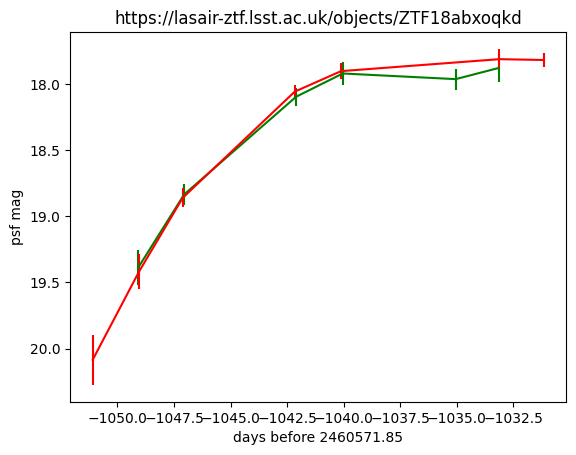

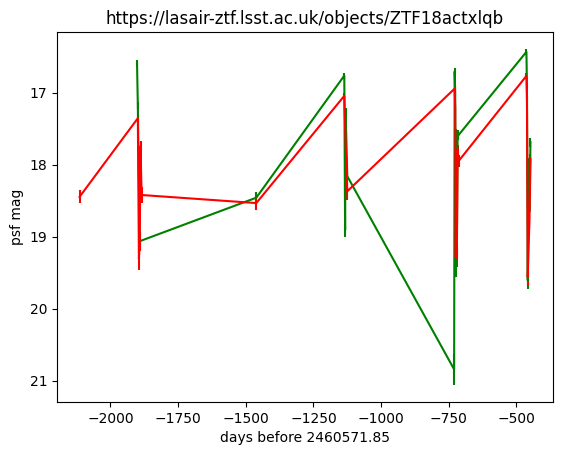

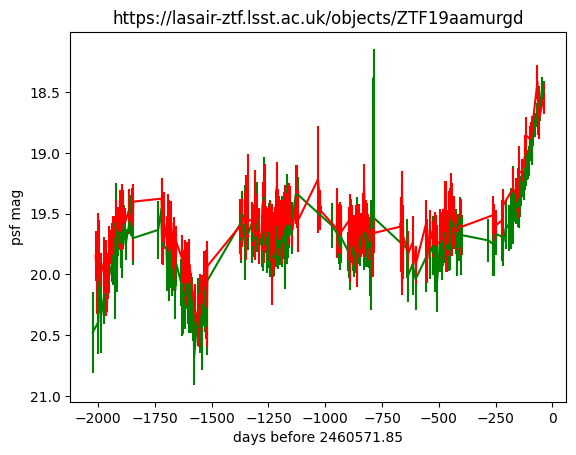

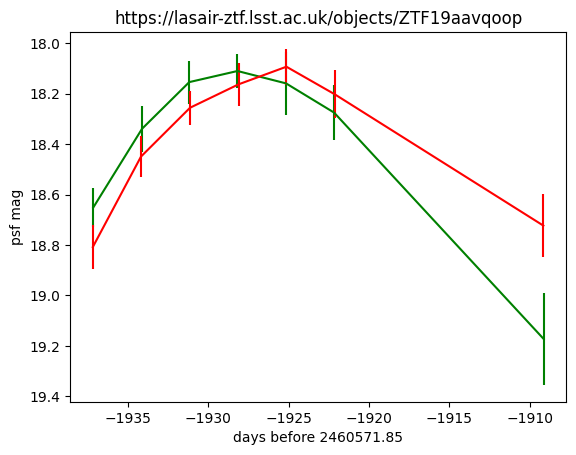

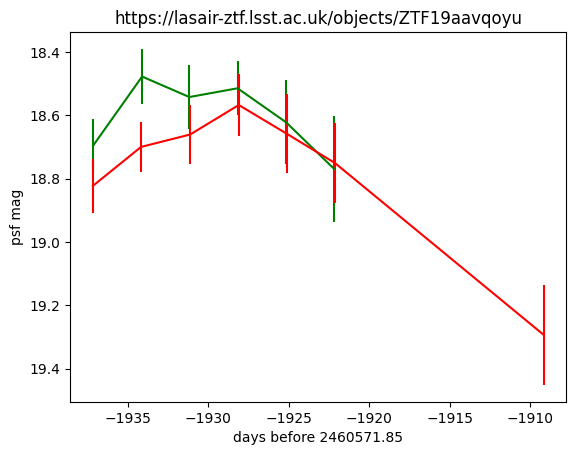

In [8]:
for obj, lc in zip(objectIds, lcs):
    candidates = []
    for l in lc['candidates']:
        if 'candid' in l.keys():
            candidates.append(l)
    plotLC(obj, candidates)